The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to Kaggle and go to the Titanic challenge to download train.csv and test.csv. Save them to the datasets/titanic directory.

Next, let's load the data:

In [1]:
import os
TITANIC_PATH = os.path.join("datasets", "titanic")

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")


The data is already split into a training set and a test set. However, the test data does not contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:


In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Bien, los atributos Edad, Camarote y Embarcado son a veces nulos (menos de 891 no nulos), especialmente el Camarote (77% son nulos). Ignoraremos la Cabina por ahora y nos centraremos en el resto. El atributo Edad tiene alrededor de un 19% de valores nulos, por lo que tendremos que decidir qué hacer con ellos. Sustituir los valores nulos por la media de edad parece razonable.

Los atributos Nombre y Billete pueden tener algún valor, pero será un poco complicado convertirlos en números útiles que un modelo pueda consumir. Así que, por ahora, los ignoraremos.

Echemos un vistazo a los atributos numéricos:

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Vaya, sólo sobrevivió el 38% :( Está bastante cerca del 40%, así que la precisión será una métrica razonable para evaluar nuestro modelo. 

* La tarifa media era de 32,20 libras, lo que no parece tan caro (pero probablemente era mucho dinero en aquella época).

* La edad media era inferior a 30 años.

Comprobemos que el objetivo es efectivamente 0 o 1:

In [7]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Ahora echemos un vistazo a todos los atributos categóricos:

In [8]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

El atributo Embarcado nos indica dónde embarcó el pasajero: C=Cherbourg, Q=Queenstown, S=Southampton.

Nota: el código siguiente utiliza una mezcla de Pipeline, FeatureUnion y un DataFrameSelector personalizado para preprocesar algunas columnas de forma diferente. Desde Scikit-Learn 0.20, es preferible utilizar un ColumnTransformer, como en el capítulo anterior.

Ahora vamos a construir nuestros pipelines de preprocesamiento. Reutilizaremos el DataframeSelector que construimos en el capítulo anterior para seleccionar atributos específicos del DataFrame:

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [13]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

También necesitaremos un imputer para las columnas categóricas de cadena (el SimpleImputer normal no funciona con ellas):

In [14]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Ahora podemos construir la pipeline para los atributos categóricos:

In [15]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [16]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Por último, unamos los conductos numéricos y categóricos:

In [17]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

¡Genial! Ahora tenemos una buena tubería de preprocesamiento que toma los datos en bruto y produce características numéricas de entrada que podemos alimentar a cualquier modelo de aprendizaje automático que queramos.

In [18]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

No olvidemos las etiquetas:

In [19]:
y_train = train_data["Survived"]

Ahora estamos preparados para entrenar un clasificador. Empecemos con un SVC:

In [20]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

Genial, nuestro modelo está entrenado, usémoslo para hacer predicciones en el conjunto de pruebas:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

Y ahora podríamos simplemente construir un archivo CSV con estas predicciones (respetando el formato exceptuado por Kaggle), luego subirlo y esperar lo mejor. Pero, ¡espera! Podemos hacer algo mejor que esperar. ¿Por qué no usamos la validación cruzada para tener una idea de lo bueno que es nuestro modelo?

In [25]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

Vale, más del 73% de precisión, claramente mejor que el azar, pero no es una gran puntuación. Mirando la tabla de clasificación de la competición del Titanic en Kaggle, puedes ver que necesitas alcanzar más del 80% de precisión para estar dentro del 10% de los mejores Kagglers. Algunos alcanzaron el 100%, pero como se puede encontrar fácilmente la lista de víctimas del Titanic, parece probable que haya habido poco aprendizaje automático en su rendimiento ;-) Así que vamos a intentar construir un modelo que alcance el 80% de precisión.

Intentemos un RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

Esto es mucho mejor.

En lugar de limitarse a observar la precisión media de los 10 fold de cross-validation, vamos a trazar las 10 puntuaciones de cada modelo, junto con un diagrama de caja que destaca los cuartiles inferior y superior, y los "bigotes" que muestran la extensión de las puntuaciones (gracias a Nevin Yilmaz por sugerir esta visualización). Obsérvese que la función boxplot() detecta los valores atípicos (llamados "volantes") y no los incluye en los bigotes. En concreto, si el cuartil inferior es $Q_1$ y el cuartil superior es $Q_3$, entonces el rango intercuartil $IQR = Q_3 - Q_1$ (esta es la altura de la caja), y cualquier puntuación inferior a $Q_1 - 1,5 \times IQR$ es un volador, y también lo es cualquier puntuación superior a $Q3 + 1,5 \times IQR$.

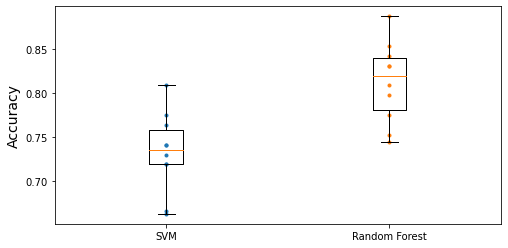

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Para mejorar aún más este resultado, se podría

* Comparar muchos más modelos y ajustar los hiperparámetros utilizando la validación cruzada y la búsqueda en la red,
* Hacer más ingeniería de características, por ejemplo:
    * sustituir SibSp y Parch por su suma,
    * intentar identificar las partes de los nombres que se correlacionan bien con el atributo Supervivencia (por ejemplo, si el nombre contiene "Condesa", la supervivencia parece más probable)
* intente convertir los atributos numéricos en atributos categóricos: por ejemplo, los distintos grupos de edad tenían tasas de supervivencia muy diferentes (véase más adelante), por lo que puede ser útil crear una categoría de cubo de edad y utilizarla en lugar de la edad. Del mismo modo, puede ser útil tener una categoría especial para las personas que viajan solas, ya que sólo el 30% de ellas sobrevivieron (véase más adelante).

In [31]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [32]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [44]:
from datetime import timedelta
from datetime import date 

class DateRangeIterable:
    """An iterable that contains its own iterator object."""
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        self._present_day = start_date
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self._present_day >= self.end_date:
            raise StopIteration
        today = self._present_day
        self._present_day += timedelta(days=1)
        return today
    
    def __str__(self):
        return "1"
    
    def __repr__(self):
        return "2"

In [45]:
itera_objet = DateRangeIterable(date(2021,6,1), date(2021,6,14))

In [46]:
itera_objet

2